Version 1.0.1

# Pandas basics 

Hi! In this programming assignment you need to refresh your `pandas` knowledge. You will need to do several [`groupby`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html)s and [`join`]()`s to solve the task. 

In [148]:
%matplotlib inline
%pylab inline
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from grader import Grader

Populating the interactive namespace from numpy and matplotlib


In [153]:
DATA_FOLDER = '../readonly/final_project_data/'

transactions    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))

The dataset we are going to use is taken from the competition, that serves as the final project for this course. You can find complete data description at the [competition web page](https://www.kaggle.com/c/competitive-data-science-final-project/data). To join the competition use [this link](https://www.kaggle.com/t/1ea93815dca248e99221df42ebde3540).

## Grading

We will create a grader instace below and use it to collect your answers. When function `submit_tag` is called, grader will store your answer *locally*. The answers will *not* be submited to the platform immediately so you can call `submit_tag` function as many times as you need. 

When you are ready to push your answers to the platform you should fill your credentials and run `submit` function in the <a href="#Authorization-&-Submission">last paragraph</a>  of the assignment.

In [154]:
grader = Grader()

# Task

Let's start with a simple task. 

<ol start="0">
  <li><b>Print the shape of the loaded dataframes and use [`df.head`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.head.html) function to print several rows. Examine the features you are given.</b></li>
</ol>

In [155]:
print(transactions.head)
print(items.head)
print(item_categories.head)
print(shops.head)

<bound method NDFrame.head of                date  date_block_num  shop_id  item_id  item_price  \
0        02.01.2013               0       59    22154      999.00   
1        03.01.2013               0       25     2552      899.00   
2        05.01.2013               0       25     2552      899.00   
3        06.01.2013               0       25     2554     1709.05   
4        15.01.2013               0       25     2555     1099.00   
...             ...             ...      ...      ...         ...   
2935844  10.10.2015              33       25     7409      299.00   
2935845  09.10.2015              33       25     7460      299.00   
2935846  14.10.2015              33       25     7459      349.00   
2935847  22.10.2015              33       25     7440      299.00   
2935848  03.10.2015              33       25     7460      299.00   

         item_cnt_day  
0                 1.0  
1                 1.0  
2                -1.0  
3                 1.0  
4                 1.0

Now use your `pandas` skills to get answers for the following questions. 
The first question is:

1. ** What was the maximum total revenue among all the shops in September, 2014?** 


* Hereinafter *revenue* refers to total sales minus value of goods returned.

*Hints:*

* Sometimes items are returned, find such examples in the dataset. 
* It is handy to split `date` field into [`day`, `month`, `year`] components and use `df.year == 14` and `df.month == 9` in order to select target subset of dates.
* You may work with `date` feature as with srings, or you may first convert it to `pd.datetime` type with `pd.to_datetime` function, but do not forget to set correct `format` argument.

In [165]:
transactions_sept = transactions.copy()
transactions_sept['date'] = pd.to_datetime(transactions_sept['date'], format='%d.%m.%Y')
mask = (transactions_sept['date'] >= '2014-09-01') & (transactions_sept['date'] <= '2014-09-30')
transactions_sept = transactions_sept.loc[mask]
transactions_sept['revenue_contribution'] = transactions_sept['item_cnt_day'] * transactions_sept['item_price']
transactions_sept.tail()

max_revenue = transactions_sept.groupby(['shop_id']).sum()['revenue_contribution'].max()
grader.submit_tag('max_revenue', max_revenue)

Current answer for task max_revenue is: 7982852.199999956


Great! Let's move on and answer another question:

<ol start="2">
  <li><b>What item category generated the highest revenue in summer 2014?</b></li>
</ol>

* Submit `id` of the category found.
    
* Here we call "summer" the period from June to August.

*Hints:*

* Note, that for an object `x` of type `pd.Series`: `x.argmax()` returns **index** of the maximum element. `pd.Series` can have non-trivial index (not `[1, 2, 3, ... ]`).

In [158]:
transactions_summer = transactions.copy()
transactions_summer['date'] = pd.to_datetime(transactions_summer['date'], format='%d.%m.%Y')
mask = (transactions_summer['date'] >= '2014-06-01') & (transactions_summer['date'] <= '2014-08-31')
transactions_summer = transactions_summer.loc[mask]
transactions_summer['revenue_contribution'] = transactions_summer['item_cnt_day'] * transactions_summer['item_price']
transactions_summer_joined = transactions_summer.join(items.set_index('item_id'), on='item_id')

category_id_with_max_revenue = transactions_summer_joined.groupby(['item_category_id']).sum()['revenue_contribution'].idxmax()

grader.submit_tag('category_id_with_max_revenue', category_id_with_max_revenue)

Current answer for task category_id_with_max_revenue is: 20


<ol start="3">
  <li><b>How many items are there, such that their price stays constant (to the best of our knowledge) during the whole period of time?</b></li>
</ol>

* Let's assume, that the items are returned for the same price as they had been sold.

In [159]:
#TODO: remove returned transactions (-1)
serie = transactions.groupby('item_id')['item_price'].nunique()

num_items_constant_price = serie.loc[serie == 1].count()
grader.submit_tag('num_items_constant_price', num_items_constant_price)

Current answer for task num_items_constant_price is: 5926


Remember, the data can sometimes be noisy.

<ol start="4">
  <li><b>What was the variance of the number of sold items per day sequence for the shop with `shop_id = 25` in December, 2014?</b></li>
</ol>

* Fill `total_num_items_sold` and `days` arrays, and plot the sequence with the code below.
* Then compute variance. Remember, there can be differences in how you normalize variance (biased or unbiased estimate, see [link](https://math.stackexchange.com/questions/496627/the-difference-between-unbiased-biased-estimator-variance)). Compute ***unbiased*** estimate (use the right value for `ddof` argument in `pd.var` or `np.var`).

/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


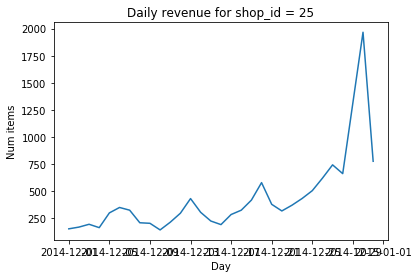

Current answer for task total_num_items_sold_var is: 117167.70229885059


In [170]:
shop_id = 25

shop_transactions = transactions.copy()
shop_transactions['date'] = pd.to_datetime(shop_transactions['date'], format='%d.%m.%Y')
mask = (shop_transactions['date'] >= '2014-12-01') & (shop_transactions['date'] <= '2014-12-31')
shop_transactions = shop_transactions.loc[mask]
shop_transactions = shop_transactions.loc[shop_transactions['shop_id'] == shop_id]

total_num_items_sold = shop_transactions.groupby('date').sum()['item_cnt_day']
days = total_num_items_sold.keys()
days

# Plot it
plt.plot(days, total_num_items_sold)
plt.ylabel('Num items')
plt.xlabel('Day')
plt.title("Daily revenue for shop_id = 25")
plt.show()

total_num_items_sold_var = total_num_items_sold.var() # PUT YOUR ANSWER IN THIS VARIABLE
grader.submit_tag('total_num_items_sold_var', total_num_items_sold_var)

## Authorization & Submission
To submit assignment to Cousera platform, please, enter your e-mail and token into the variables below. You can generate token on the programming assignment page. *Note:* Token expires 30 minutes after generation.

In [171]:
STUDENT_EMAIL = 'mathiou.sanchez@gmail.com'# EMAIL HERE
STUDENT_TOKEN = 'Rq2SdryjTRsQlbD6' # TOKEN HERE
grader.status()

You want to submit these numbers:
Task max_revenue: 7982852.199999956
Task category_id_with_max_revenue: 20
Task num_items_constant_price: 5926
Task total_num_items_sold_var: 117167.70229885059


In [172]:
grader.submit(STUDENT_EMAIL, STUDENT_TOKEN)

Submitted to Coursera platform. See results on assignment page!


Well done! :)